# Feature Engineering

## Import Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
# Change this variable to 0 if you use jupyter notebook, or 1 if you use google colab
use_colab = 0

import os
if use_colab:
    from google.colab import files
    import io

if os.path.exists('dataset'):
    print('Dataset folder exists')
else:
    print('Dataset folder not exists. A dataset folder will be created.')
    os.mkdir('dataset')

def file_exists(parent_directory, file_name):
    path = os.path.join(parent_directory, file_name)
    if os.path.exists(path):
        return 1
    else:
        return 0
    
def read_csv_file(use_colab, file_name):
    if file_exists('dataset', file_name):
        return pd.read_csv('dataset/'+file_name)
    else:
        print("Please upload the file or create one by running previous section's csv export.")
        if use_colab:
            print("Please upload file: {}".format(file_name))
            upload_file = files.upload()
            return pd.read_csv(io.BytesIO(upload_file[file_name]))

Dataset folder exists


In [3]:
train = read_csv_file(use_colab, 'train_EDA.csv')
test = read_csv_file(use_colab, 'test_EDA.csv')
weather = read_csv_file(use_colab, 'weather_EDA.csv')

In [4]:
# Set Date column as index
## Write function to be run on both train and test set later on
def datetime_setter(df):    
    df['Date'] = pd.to_datetime(df['Date'], format=("%Y-%m-%d")).copy()
    df.set_index(keys=['Date'], inplace=True)

In [5]:
datetime_setter(train)
datetime_setter(test)
datetime_setter(weather)

## Number of Dark Hours

Most 'household' mosquitos tend to be active biting humans in the evening or a few hours before evening. This is because, exposure of sunlight dehydrates and kills them ([source](https://tickkillz.com/2018/11/07/what-time-of-day-are-mosquitos-most-active/)). Therefore, we will create another feature to compute the number of non-daylight hours on each particular day based on Sunset and Sunrise timing.

Before performing the deduction, we will convert each Sunset and Sunrise value to integer representation to simplify the computation. 

In [6]:
# Function to covert time to the equivalent float representation, i.e. cast hour to integer, minute to decimal
def conv_time_to_float(time_):
    ## Extract the last two digits (as minutes)
    time_ /= 100
    min_ = time_ % 1
    ### Convert minute to decimal representation
    min_conv = min_ / .6
    
    ## Extract the first two digits (as hours)
    hour_ = round(time_ - min_ ,0)
    
    ## Return float representation of the time
    return hour_ + min_conv

In [7]:
weather['Sunset'] = weather['Sunset'].apply(lambda x: conv_time_to_float(x))
weather['Sunrise'] = weather['Sunrise'].apply(lambda x: conv_time_to_float(x))
weather['DarkHours'] = 24 - (weather['Sunset'] - weather['Sunrise'])
weather.head(2)

,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,AvgSpeed,Depart,Sunset,Sunrise,Precip_1,Precip_2,week_of_year,DarkHours
Date,,,,,,,,,,,,,,,
2007-05-01,83.5,51.0,67.5,51.0,56.5,0.0,2.5,9.4,14,18.816667,4.800000,0.0,0.0,18,9.983333
2007-05-02,59.5,42.5,51.5,42.0,47.0,13.5,0.0,13.4,-3,18.833333,4.783333,0.0,0.0,18,9.950000


### Correlation between Dark Hours and Number of Mosquitos

In [8]:
mos_pop_df = pd.DataFrame(index=weather.index)
mos_pop_df = mos_pop_df.merge(train.groupby(['Date'])[['NumMosquitos', 'WnvPresent']].sum(),
                              left_index=True, right_index=True, how='left').fillna(0)

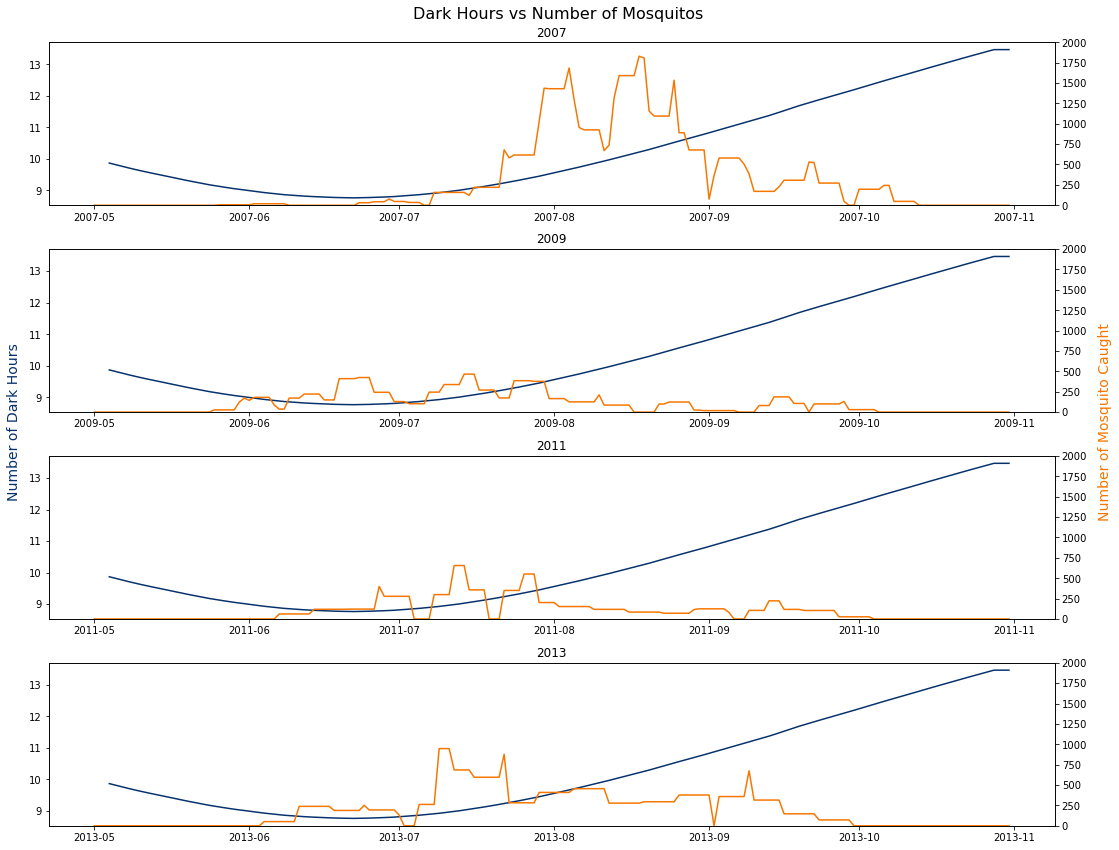

In [9]:
years = ['2007', '2009', '2011', '2013']
fig, ax = plt.subplots(nrows=4, figsize=(15,12), sharey=True)
ax=ax.ravel()
plt.suptitle('Dark Hours vs Number of Mosquitos', fontsize=16)
for i, year in enumerate(years):
    ax[i].set_title(str(year), fontsize=12)
    ax[i].plot(weather.loc[str(year)].index,
               weather.loc[str(year)]['DarkHours'].rolling(7, center=True).mean().fillna(method='ffill'),
               color='#07316c')
    ax2=ax[i].twinx()
    ax2.plot(mos_pop_df.loc[str(year)].index,
               mos_pop_df.loc[str(year)]['NumMosquitos'].rolling(7, center=True).mean().fillna(mos_pop_df.loc[str(year)]['NumMosquitos'][0]),
               color='#f67600')
    ax2.set_ylim([0, 2000])
    
fig.text(-0.01, 0.5, 'Number of Dark Hours', va='center', rotation='vertical', color='#07316c', fontsize=14)
fig.text(1, 0.5,  'Number of Mosquito Caught', va='center', rotation='vertical', color='#f67600', fontsize=14)
plt.tight_layout()

**Observations:**
- In a glance, there is no clear relationship between the number of Dark Hours and Mosquito population.
- However, the longer the dark hours, the longer mosquito feeding time which can be correlated to the increase risk of human transmission due to mosquito bite. 

## Humidity

In general, mosquito is more active when humidity is high. On the other hand, low humidity surpress mosquito activity and may even cause mosquito mortality ([source](https://www.orkin.com/other/mosquitoes/activity#:~:text=Warm%20temperatures%20of%20approximately%2080,and%20may%20even%20cause%20mortality.)). Therefore, humidity is worth looking into. 

Formula of Relative Humidity is given as ([source](http://hyperphysics.phy-astr.gsu.edu/hbase/Kinetic/relhum.html)):

$\ln RH=\frac{\frac{}{}\frac{T_d{}}{b}(a-\frac{aT}{b+T}) - \frac{aT}{b+T}}{\frac{T_d{}}{b} + 1}$

where $a$ = 17.27, $b$ = 237.7, $T$ = Temperature in Celcius, $T_d$ = Dew Point Temperature in Celcius

In [10]:
def farenheit_to_celcius(x):
    c = ((x - 32) * 5.0)/9.0
    return c

In [11]:
def relative_humidity(avg_temp, dew_point):
    a = 17.27
    b = 237.7
    avg_temp = farenheit_to_celcius(avg_temp)
    dew_point = farenheit_to_celcius(dew_point)
    Td_b = dew_point / b
    aT_bT = a*avg_temp / (b+avg_temp)
    ln_rh = Td_b*(a-aT_bT) - aT_bT / (Td_b + 1)
    return np.exp(ln_rh)

In [12]:
weather['RelHumidity'] = weather.apply(lambda x: relative_humidity(x['Tavg'], x['DewPoint']), axis=1)

### Correlation to Number of Mosquito

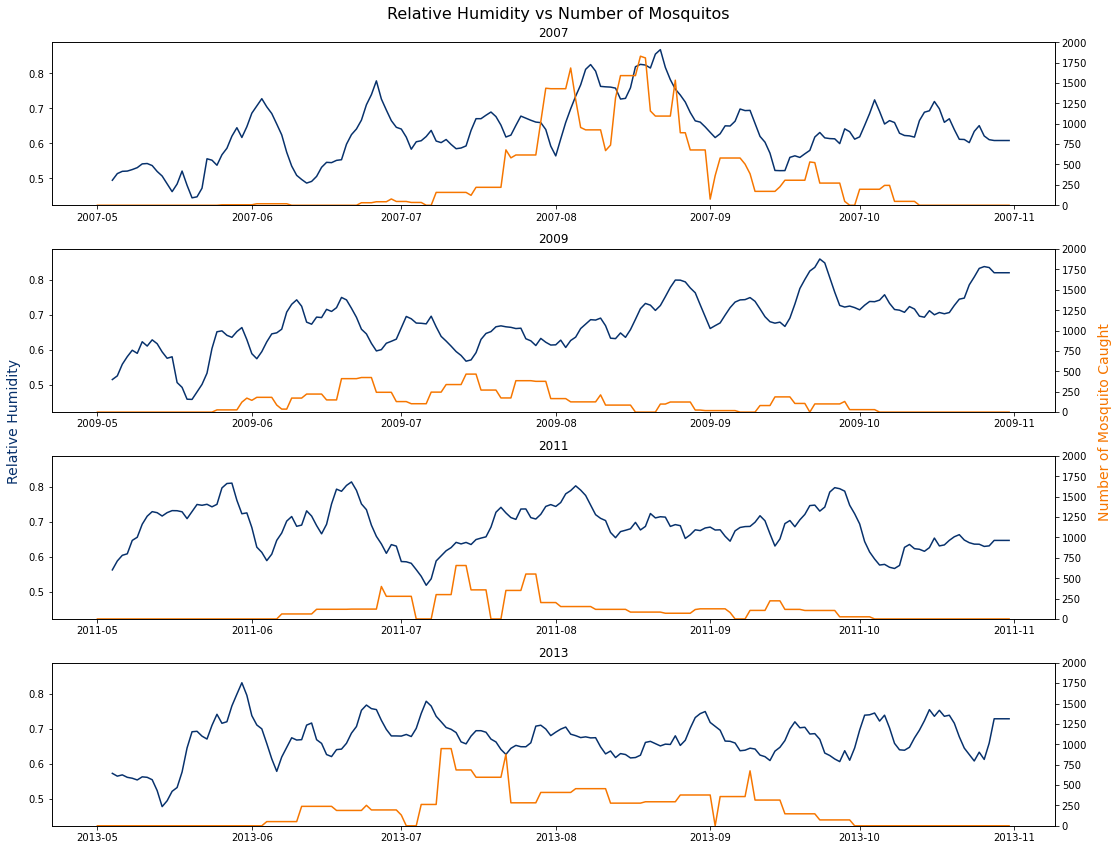

In [13]:
years = ['2007', '2009', '2011', '2013']
fig, ax = plt.subplots(nrows=4, figsize=(15,12), sharey=True)
ax=ax.ravel()
plt.suptitle('Relative Humidity vs Number of Mosquitos', fontsize=16)
for i, year in enumerate(years):
    ax[i].set_title(str(year), fontsize=12)
    ax[i].plot(weather.loc[str(year)].index,
               weather.loc[str(year)]['RelHumidity'].rolling(7, center=True).mean().fillna(method='ffill'),
               color='#07316c')
    ax2=ax[i].twinx()
    ax2.plot(mos_pop_df.loc[str(year)].index,
               mos_pop_df.loc[str(year)]['NumMosquitos'].rolling(7, center=True).mean().fillna(mos_pop_df.loc[str(year)]['NumMosquitos'][0]),
               color='#f67600')
    ax2.set_ylim([0, 2000])
    
fig.text(-0.01, 0.5, 'Relative Humidity', va='center', rotation='vertical', color='#07316c', fontsize=14)
fig.text(1, 0.5,  'Number of Mosquito Caught', va='center', rotation='vertical', color='#f67600', fontsize=14)
plt.tight_layout()

**Observations:**
- Generally, a drop in relative humidity cause the mosquito population to also decrease. This supports claims from multiple sources ([source](https://www.orkin.com/other/mosquitoes/activity), [source](https://parasitesandvectors.biomedcentral.com/articles/10.1186/s13071-017-2025-8)) which highlight that mosquito prefers humid weather as dry air cause it to be dehydrated and die. 

## Distance between each trap to the Station

As Precipitation is shown to be varied for both the station, the relative location between the station and the trap is crucial in determining the actual effect of the precipitation to the trap localities. Therefore, trap distance to each station will be included as one of the feature in the model.

In [14]:
train_trap = list(train.Trap.unique())
test_trap = list(test.Trap.unique())
traps = set(train_trap + test_trap)

In [15]:
def distance_finder(coordinate_1, coordinate_2):
    return np.sqrt((coordinate_1[0]-coordinate_2[0])**2 + (coordinate_1[1]-coordinate_2[1])**2)

In [16]:
traps_loc = dict()
for trap in traps:
    try:
        lat = train[train['Trap'] == trap]['Latitude'].iloc[0]
        long = train[train['Trap'] == trap]['Longitude'].iloc[0]
    except IndexError:
        lat = test[test['Trap'] == trap]['Latitude'].iloc[0]
        long = test[test['Trap'] == trap]['Longitude'].iloc[0]
    traps_loc[trap] = [lat, long]

In [17]:
# Location of each station
stat_1_loc = [41.995, -87.933]
stat_2_loc = [41.786, -87.752]

In [18]:
traps_dist_dict = dict()
for trap in traps:
    traps_dist = dict()
    traps_dist['dist_to_stat_1'] = distance_finder(stat_1_loc, traps_loc[trap])
    traps_dist['dist_to_stat_2'] = distance_finder(stat_2_loc, traps_loc[trap])    
    traps_dist_dict[trap] = traps_dist

pd.DataFrame(traps_dist_dict)

,T091,T089,T012,T083,T238,T069,T049,T027,T231,T028,T228,T082,T115,T160,T145,T235,T047,T070,T006,T005,T067,T085,T019,T090A,T200B,T148,T142,T212,T054C,T159,T086,T065A,T218,T150,T081,T009A,T063,T033,T011,T045,T008,T007,T013,T088,T092,T162,T073,T084,T223,T015,T077,T232,T054,T147,T094B,T036,T222,T153,T002A,T129,T080,T062,T155,T099,T200,T090B,T094,T157,T146,T072,T900,T066,T221,T218C,T128,T154,T039,T090,T226,T218A,T075,T001,T051,T004,T065,T200A,T100,T227,T219,T035B,T078,T043,T215,T156,T061,T009B,T236,T002,T103,T141,T102,T096,T218B,T048,T046,T044,T034,T040,T076,T229,T002B,T161,T060,T025,T079,T903,T206,T128A,T114,T074,T143,T151,T018,T014,T097,T225,T090C,T035A,T017,T234,T220,T230,T233,T031,T237,T149,T158,T050,T037,T095,T138,T107,T152,T209,T030,T071,T016,T135,T144,T003,T224
dist_to_stat_1,0.313603,0.392408,0.185921,0.418401,0.330565,0.340657,0.294789,0.204762,0.267046,0.243356,0.21237,0.347579,0.463036,0.261453,0.324952,0.375967,0.268579,0.239195,0.135955,0.165303,0.301083,0.394975,0.238853,0.411075,0.522427,0.246255,0.161738,0.506830,0.307336,0.385933,0.399669,0.284649,0.207652,0.257354,0.351032,0.120878,0.267049,0.247855,0.112074,0.276467,0.155649,0.163721,0.164003,0.268103,0.330325,0.417394,0.399365,0.450687,0.129678,0.110190,0.408507,0.277474,0.309651,0.241229,0.381458,0.257675,0.199246,0.193013,0.153863,0.337807,0.400257,0.294333,0.26764,0.459136,0.489636,0.299385,0.382676,0.314501,0.233334,0.337807,0.047000,0.320561,0.517976,0.204026,0.468276,0.196120,0.222402,0.294819,0.343780,0.206075,0.398837,0.203265,0.313593,0.187432,0.282086,0.465850,0.487793,0.425762,0.259837,0.299750,0.354209,0.274921,0.506289,0.294262,0.319148,0.070050,0.162101,0.138026,0.492585,0.176099,0.408867,0.366721,0.197272,0.306712,0.297252,0.253822,0.288948,0.256281,0.374945,0.379897,0.150094,0.377706,0.307236,0.182743,0.435121,0.037255,0.467531,0.446290,0.277533,0.317569,0.137477,0.154115,0.271298,0.147105,0.480297,0.322382,0.425528,0.300393,0.159560,0.179203,0.243177,0.198796,0.126600,0.257297,0.349312,0.265265,0.385018,0.250442,0.156346,0.370199,0.439235,0.439444,0.262959,0.462616,0.236473,0.264765,0.122623,0.392819,0.148594,0.178038,0.265870
dist_to_stat_2,0.128290,0.119811,0.205487,0.164315,0.055254,0.075436,0.146718,0.200194,0.218857,0.210335,0.16804,0.110399,0.189269,0.133234,0.153030,0.125270,0.099264,0.047341,0.209209,0.158007,0.027411,0.122337,0.172358,0.134809,0.250623,0.240178,0.168896,0.240914,0.183095,0.115273,0.123326,0.008786,0.163560,0.233595,0.129200,0.205187,0.047082,0.130808,0.178219,0.160329,0.223820,0.209704,0.141703,0.100050,0.149700,0.150436,0.151660,0.179394,0.195195,0.201691,0.165732,0.151872,0.181290,0.155033,0.106161,0.055867,0.139311,0.121969,0.182056,0.175428,0.142562,0.042741,0.02867,0.203346,0.220593,0.122381,0.107881,0.093152,0.179221,0.062324,0.234132,0.051010,0.248194,0.148276,0.203349,0.132705,0.128335,0.118231,0.098078,0.170085,0.167042,0.168671,0.112586,0.176765,0.007714,0.210522,0.230670,0.161614,0.196812,0.024287,0.097262,0.091369,0.241829,0.017786,0.074124,0.234421,0.209533,0.175660,0.231033,0.175928,0.150941,0.092048,0.162630,0.127038,0.143380,0.108006,0.087166,0.073985,0.136294,0.116821,0.170006,0.101963,0.082426,0.193246,0.190145,0.248101,0.214590,0.190277,0.019796,0.093124,0.217540,0.139006,0.241734,0.187731,0.204322,0.047302,0.149079,0.089888,0.176423,0.156587,0.187878,0.118267,0.230599,0.019249,0.073599,0.224855,0.112395,0.145308,0.141906,0.094860,0.176906,0.178426,0.069894,0.210361,0.118579,0.024957,0.233317,0.126976,0.160017,0.178331,0.180226


In [19]:
train['dist_to_stat_1'] = train.apply(lambda x: traps_dist_dict[x['Trap']]['dist_to_stat_1'], axis=1)
train['dist_to_stat_2'] = train.apply(lambda x: traps_dist_dict[x['Trap']]['dist_to_stat_2'], axis=1)
test['dist_to_stat_1'] = test.apply(lambda x: traps_dist_dict[x['Trap']]['dist_to_stat_1'], axis=1)
test['dist_to_stat_2'] = test.apply(lambda x: traps_dist_dict[x['Trap']]['dist_to_stat_2'], axis=1)
train.head(2)

,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,week_of_year,dist_to_stat_1,dist_to_stat_2
Date,,,,,,,,,
2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1,0,22,0.138026,0.17566
2007-05-29,CULEX RESTUANS,T002,41.95469,-87.800991,1,0,22,0.138026,0.17566


In [20]:
test.head(2)

,Id,Species,Trap,Latitude,Longitude,week_of_year,dist_to_stat_1,dist_to_stat_2
Date,,,,,,,,
2008-06-11,1,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,24,0.138026,0.17566
2008-06-11,2,CULEX RESTUANS,T002,41.95469,-87.800991,24,0.138026,0.17566


## Mosquito Species

### Infection Rate Modelling

Previusly in EDA section, we observed that the rate of infection for different mosquito species is varied over month. More interestingly, this pattern seems to repeat at similar time of the year for all observable years. Therefore, we would like to create **a variable which capture the infection rate of the species for every week of the year**.  

The infection rate is defined as the number of trap containing WNV divided by the number of Mosquitos caught for a period of a week for a particular mosquito. 

#### For Train Set

In [21]:
# First, we will obtain the Num of Mosquitos caught and Wnv Present for every mosquito 
# species in each week from the train set
infection_rate_df = train.groupby(['week_of_year', 'Species'])[['NumMosquitos', 'WnvPresent']].sum()
infection_rate_df.reset_index(inplace=True)
infection_rate_df.head(2)

,week_of_year,Species,NumMosquitos,WnvPresent
0,22,CULEX PIPIENS,4,0
1,22,CULEX PIPIENS/RESTUANS,114,0


In [22]:
# Next we will compute the infection rate
infection_rate_df['infection_rate'] = infection_rate_df['WnvPresent'] / infection_rate_df['NumMosquitos']
infection_rate_df.head(2)

,week_of_year,Species,NumMosquitos,WnvPresent,infection_rate
0,22,CULEX PIPIENS,4,0,0.0
1,22,CULEX PIPIENS/RESTUANS,114,0,0.0


In [23]:
# Impute these values into the train set for model training
for index, row in train.iterrows():
    train.loc[index, 'infection_rate'] = \
    infection_rate_df.loc[(infection_rate_df['week_of_year'] == row['week_of_year']) & (infection_rate_df['Species'] == row['Species']), 'infection_rate'].values[0]

#### For Test Set

Note that there is an unspecified species on the test set, we will impute average infection rate for all species for this category.

In [24]:
# Find the average infection rate per week
infection_rate_mean_df = train.groupby(['week_of_year'])[['NumMosquitos', 'WnvPresent']].sum()
infection_rate_mean_df.reset_index(inplace=True)
infection_rate_mean_df.head(2)

,week_of_year,NumMosquitos,WnvPresent
0,22,230,0
1,23,2184,0


In [25]:
# We will compute the average infection rate per week for all species combined
infection_rate_mean_df['infection_rate'] = infection_rate_mean_df['WnvPresent'] / infection_rate_mean_df['NumMosquitos']
infection_rate_mean_df.head(2)

,week_of_year,NumMosquitos,WnvPresent,infection_rate
0,22,230,0,0.0
1,23,2184,0,0.0


In [26]:
# Impute the values on test set 
for week in list(test['week_of_year'].unique()):
    for moz in list(test['Species'].unique()):
        ## For unspecified species, we will impute the average infection rate
        if moz == 'UNSPECIFIED CULEX':
            test.loc[(test['week_of_year'] == week) & (test['Species'] == moz), 'infection_rate'] = \
            infection_rate_mean_df[infection_rate_mean_df['week_of_year'] == week]['infection_rate'].iloc[0]
        else:
            ## For other species, we will impute the infection rate based on the species' infection rate on that week
            try:
                test.loc[(test['week_of_year'] == week) & (test['Species'] == moz), 'infection_rate'] = \
                infection_rate_df[(infection_rate_df['week_of_year'] == week) & 
                                      (infection_rate_df['Species'] == moz)]['infection_rate'].iloc[0]
            ## For other species with no infection rate on training data, average infection rate will be used
            except:
                test.loc[(test['week_of_year'] == week) & (test['Species'] == moz), 'infection_rate'] = \
                infection_rate_mean_df[infection_rate_mean_df['week_of_year'] == week]['infection_rate'].iloc[0]

## High Infection Areas

To represent the location better, we will cluster them into groupings based on the location and historical mosquito population and the presence of WNV. Clustering is done by the means of K-Means and number of cluster will be searched to find the most optimum based on how it naturally clasify the traps.

In [27]:
trap_loc = train.groupby('Trap')[['Latitude', 'Longitude']].max()
trap_stat = train.groupby('Trap')[['NumMosquitos','WnvPresent']].sum()
traps_df = trap_loc.merge(trap_stat, left_index=True, right_index=True)
traps_df.head(2)

,Latitude,Longitude,NumMosquitos,WnvPresent
Trap,,,,
T001,41.953705,-87.733974,25,0
T002,41.954690,-87.800991,3710,15


In [28]:
# As clustering is done by K-Means framework, all features need to be scaled first
ss = StandardScaler()
traps_s = ss.fit_transform(traps_df)

# KMeans is deployed to cluster the traps
kmeans = KMeans(n_clusters=5)
kmeans.fit(traps_s)

# Result of clustering is kept in DataFrame format
trap_group = pd.DataFrame(data = kmeans.predict(traps_s), columns=['trap_group'], index=traps_df.index)
traps_df = traps_df.merge(trap_group, left_index=True, right_index=True)

In [29]:
traps_df.groupby(['trap_group'])[['WnvPresent','NumMosquitos']].mean()

,WnvPresent,NumMosquitos
trap_group,,
0,1.213115,285.934426
1,22.000000,18527.000000
2,7.227273,1179.409091
3,6.450000,1875.050000
4,1.545455,518.030303


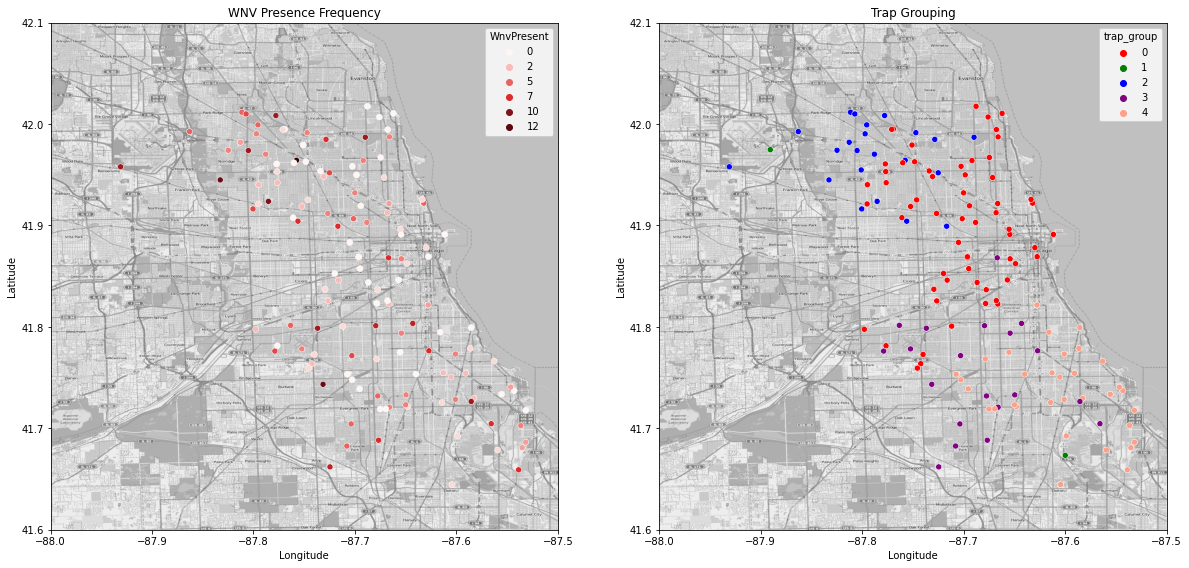

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 15))
ax=ax.ravel()
origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

mapdata = np.loadtxt("./dataset/mapdata_copyright_openstreetmap_contributors.txt")

intersection = [41.909614, -87.746134]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth

# generate map
ax[0].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
ax[1].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

# points showing west nile virus presence
sns.scatterplot(data = traps_df[traps_df['WnvPresent']<15], x='Longitude', y='Latitude', hue='WnvPresent', ax=ax[0],
                palette=('blend:#fef6f3,#f48e8a,#da2b2b,#6f0f18,#3c0002'))
ax[0].set_title('WNV Presence Frequency')
sns.scatterplot(data = traps_df, x='Longitude', y='Latitude', hue='trap_group', ax=ax[1],
               palette=('blend:red,green,blue,purple,#fca08a'))
ax[1].set_title('Trap Grouping');

**Observation:**
- With the n_clusters = 5, we can see that the traps are nicely divided into 5 groupings, i.e.:
    - North cluster with medium-high infection rate: Group 0 (in red)
    - North-City Center cluster with medium-low infection rate: Group 2 (in blue)
    - South cluster with low infection rate: Group 1 (in green)
    - South cluster with medium-high infection rate: Group 4 (in pink)
    - High infection rate (outliers) cluster (no strong geographical pattern): Group 3 (in purple)
    
- To avoid confusion that the number represents the order of infection rate. They will be renamed accordingly to:
    - Group 0: north_high
    - Group 1: south_low
    - Group 2: north_low
    - Group 3: high_rate
    - Group 4: south_high
    
With this insight, we will categorize the traps according to the groupings to represent the trap location and its historical infection rate. 

In [31]:
traps_df['trap_group']=traps_df['trap_group'].map({0:'north_high',
                                                   1:'south_low',
                                                   2:'north_low',
                                                   3:'high_rate',
                                                   4:'south_high'})

### Create Trap Group Variable

In [32]:
# For train set we will just impute it accordingly
train = train.merge(traps_df[['trap_group']], left_on='Trap', right_index=True)

For traps on test set not appearing on train set, they will be categorized to the nearest centroid.

In [33]:
group_centroids = traps_df.groupby(['trap_group'])[['Latitude', 'Longitude']].mean()
group_centroids

,Latitude,Longitude
trap_group,,
high_rate,41.753334,-87.684699
north_high,41.901474,-87.706041
north_low,41.967813,-87.788849
south_high,41.735481,-87.605755
south_low,41.824049,-87.745238


In [34]:
new_traps = [trap for trap in set(test['Trap']) if trap not in set(train['Trap'])]
np.array(new_traps)

array(['T090A', 'T200B', 'T065A', 'T002A', 'T090B', 'T218C', 'T218A',
       'T200A', 'T218B', 'T002B', 'T128A', 'T090C', 'T234'], dtype='<U5')

In [35]:
def trap_grouper(trap_coordinate):
    dist = np.exp(100)
    group = group_centroids.index
    for i in range(5):
        current_distance = distance_finder(trap_coordinate, tuple(group_centroids.iloc[i,:]))
        if (current_distance < dist) & (group[i]!='high_rate'):
            trap_group = group[i]
            dist = current_distance
    return trap_group

In [36]:
new_traps_df = pd.DataFrame(index=new_traps)
new_traps_df = new_traps_df.merge(test.groupby(['Trap'])[['Latitude', 'Longitude']].max(),
                   left_index=True,
                   right_index=True, how='left')

new_traps_df['trap_group']=new_traps_df.apply(lambda x: trap_grouper((x['Latitude'], x['Longitude'])), axis=1)

traps_df = pd.concat([traps_df, new_traps_df], axis=0)

# Impute values for test set accordingly
test = test.merge(traps_df[['trap_group']], left_on='Trap', right_index=True)

### Creating Dummy for Trap Group

In [37]:
# Perform One Hot Encoding on the newly created group
one_hot = OneHotEncoder(drop=None, handle_unknown='ignore')

train.reset_index(inplace=True)
test.reset_index(inplace=True)

train_trap_group = pd.DataFrame(one_hot.fit_transform(train[['trap_group']]).todense(),
                    columns=one_hot.categories_,
                   index=train.index)

train = train.merge(train_trap_group, left_index=True, right_index=True)
train.drop(columns=['trap_group'], inplace=True)

test_trap_group = pd.DataFrame(one_hot.transform(test[['trap_group']]).todense(),
                    columns=one_hot.categories_,
                   index=test.index)

test = test.merge(test_trap_group, left_index=True, right_index=True)
test.drop(columns=['trap_group'], inplace=True)

datetime_setter(train)
datetime_setter(test)

## Smoothening of Data

Weather data is provided in day to day form. This cause us to have a noisy data that may cloud the actual signal that it can provide. Therefore, we will smoothen the data by taking rolling average of the weather features. Features to be smoothened are:
- Tavg
- DewPoint
- WetBulb
- RelHumidity
- AvgSpeed

In [38]:
columns_to_smoothen = ['Tavg', 'DewPoint', 'WetBulb', 'RelHumidity', 'AvgSpeed']
new_column_names = []
for columns in columns_to_smoothen:
    new_column_names.append(columns + '_Rol7')
    
weather[new_column_names] = weather[columns_to_smoothen].rolling(7, center=True).mean().fillna(method='ffill').fillna(method='bfill')

## Removal of Features

Some features may have high correlation with each other while other features have little/ no correlation to the presence of West Nile Virus. These features will be removed to ensure we only train important features in the final model.

### Training Dataset

Columns to remove and their reasons are: 
- Trap: information is already included within the trap grouping features
- NumMosquitos: despite having a high correlation to presence of virus, number of mosquitos is not provided in the test set, therefore, will be removed.
- Species: information about how infectious the species are is already contained within infection_rate column

In [39]:
columns_to_remove = ['Trap', 'NumMosquitos', 'Species']
train.drop(columns=columns_to_remove, inplace=True)

### Testing Dataset

Columns to remove and their reasons are: 
- Trap: information is already included within the trap grouping features
- Species: information about how infectious the species are is already contained within infection_rate column

In [40]:
columns_to_remove = ['Trap', 'Species']
test.drop(columns=columns_to_remove, inplace=True)

### Weather Dataset

Columns to remove and their reasons are: 
- Tmin, Tmax: due to high correlation to Tavg
- Precip_1, Precip_2: no observable correlation to the target variable
- Tavg, DewPoint, WetBulb, RelHumidity, AvgSpeed: these are original features which we already smootened. We will use only the smoothened features subsequently. 

In [41]:
columns_to_remove = ['Tmin', 'Tmax', 'Precip_1', 'Precip_2', 'Sunset', 'Sunrise'] + columns_to_smoothen
weather.drop(columns=columns_to_remove, inplace=True)

## Final Dataset

After performing the feature engineering on the dataset, we are going to merge train and weather dataset to be used for model training subsequently. 

In [42]:
train_weather = train.merge(weather, left_on=['Date', 'week_of_year'], right_on=['Date', 'week_of_year'], how='left')

In [43]:
test_weather = test.merge(weather, left_on=['Date', 'week_of_year'], right_on=['Date', 'week_of_year'], how='left')

In [44]:
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8475 entries, 2007-05-29 to 2013-09-19
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Latitude          8475 non-null   float64
 1   Longitude         8475 non-null   float64
 2   WnvPresent        8475 non-null   int64  
 3   week_of_year      8475 non-null   int64  
 4   dist_to_stat_1    8475 non-null   float64
 5   dist_to_stat_2    8475 non-null   float64
 6   infection_rate    8475 non-null   float64
 7   (high_rate,)      8475 non-null   float64
 8   (north_high,)     8475 non-null   float64
 9   (north_low,)      8475 non-null   float64
 10  (south_high,)     8475 non-null   float64
 11  (south_low,)      8475 non-null   float64
 12  Heat              8475 non-null   float64
 13  Cool              8475 non-null   float64
 14  Depart            8475 non-null   int64  
 15  DarkHours         8475 non-null   float64
 16  Tavg_Rol7         8475 n

In [45]:
test_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116293 entries, 2008-06-11 to 2014-10-02
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                116293 non-null  int64  
 1   Latitude          116293 non-null  float64
 2   Longitude         116293 non-null  float64
 3   week_of_year      116293 non-null  int64  
 4   dist_to_stat_1    116293 non-null  float64
 5   dist_to_stat_2    116293 non-null  float64
 6   infection_rate    116293 non-null  float64
 7   (high_rate,)      116293 non-null  float64
 8   (north_high,)     116293 non-null  float64
 9   (north_low,)      116293 non-null  float64
 10  (south_high,)     116293 non-null  float64
 11  (south_low,)      116293 non-null  float64
 12  Heat              116293 non-null  float64
 13  Cool              116293 non-null  float64
 14  Depart            116293 non-null  int64  
 15  DarkHours         116293 non-null  float64
 16  Tavg

## File Export

In [46]:
train_weather.to_csv('dataset/train_weather_FE.csv')
test_weather.to_csv('dataset/test_weather_FE.csv')
train.to_csv('dataset/train_FE.csv')
test.to_csv('dataset/test_FE.csv')
weather.to_csv('dataset/weather_FE.csv')